In [1]:
# Kütüphanelerimizi import edelim;

import pandas as pd 
import numpy as np 
import time
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf

import datetime as dt
import matplotlib.dates as mdates

import et_analysis as et

In [2]:
# Pandas ve warnings ayarlamalarını yapalım;

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
# Verilerimizi import edelim;
df = pd.read_csv("ml_covid_case_data_adj.csv")

politics = pd.read_excel("covid_politics.xlsx")
politics.drop("Vaka_arttırıcı_olay", axis=1, inplace=True)

df = pd.concat([df, politics], axis=1)
df.drop("Date", axis=1, inplace=True)

# Covid verisinin tarihinde bozukluk olduğu için onu drop ettik.

In [4]:
# Sütun orderlarını düzenleyelim;

df = df[['Date2', 'Case', 'Death', 'Recovered', 
         'Month', 'Season', 'Weekday', 'Weekend', 
         'OfficailHoliday', 'BusinessDay', 
         'Doses_admin', 'People_partially_vaccinated', 'People_fully_vaccinated', 
         'Tam_kapanma', 'Kısmi_kapanma', 'Açık', 'Vaka_azaltıcı_olay']]

df = df.rename(columns={'Date2': 'Date'})
df.sort_values(by="Date").head()

,Date,Case,Death,Recovered,Month,Season,Weekday,Weekend,OfficailHoliday,BusinessDay,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Tam_kapanma,Kısmi_kapanma,Açık,Vaka_azaltıcı_olay
0,2020-03-11,1,0,0,3,2,1,0,0,0,0,0,0,0,0,1,0
1,2020-03-12,1,0,0,3,2,1,0,0,0,0,0,0,0,0,1,0
2,2020-03-13,5,0,0,3,2,1,0,0,0,0,0,0,0,0,1,0
3,2020-03-14,5,0,0,3,2,0,1,0,1,0,0,0,0,0,1,0
4,2020-03-15,6,0,0,3,2,0,1,0,1,0,0,0,0,0,1,0


In [5]:
# İstatistiklerimiz kümülatif, bu sebeple o günkü yeni istatistikleri görmek adına fark alalım,

main_col = ["Case", "Death", "Recovered"]

for col in main_col:
    df[f"lag_1_{col}"] = df[col].shift(1)
    df[f"{col}_new"] = df[col] - df[f"lag_1_{col}"]
    df.drop(f"lag_1_{col}", axis=1, inplace=True)

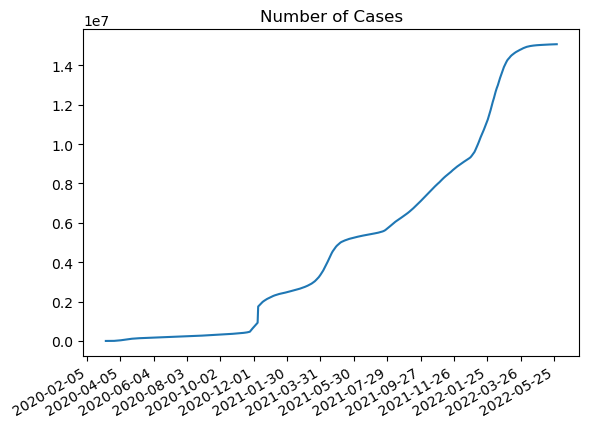

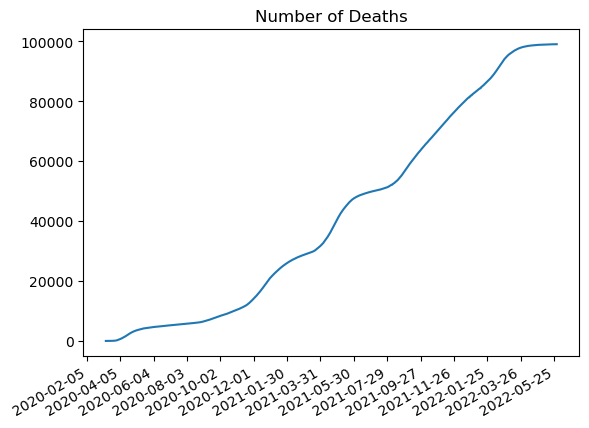

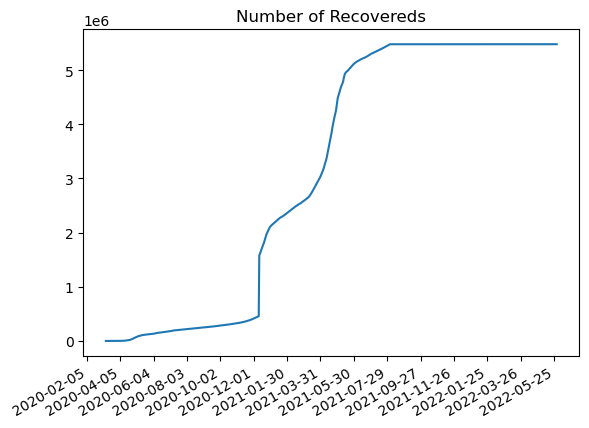

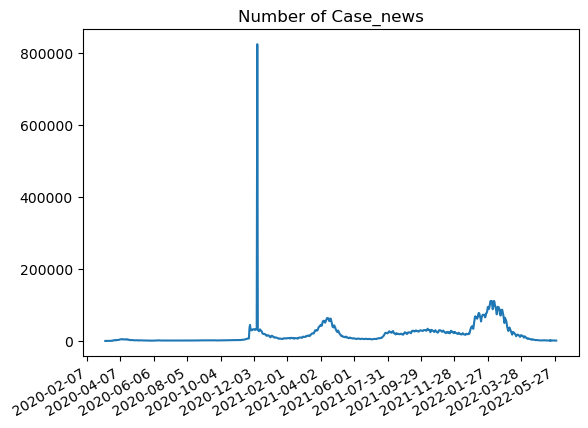

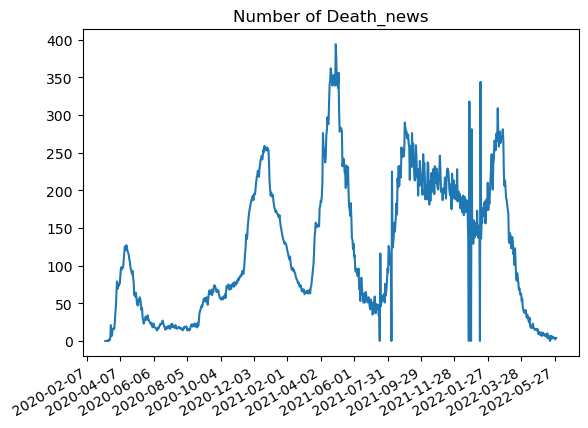

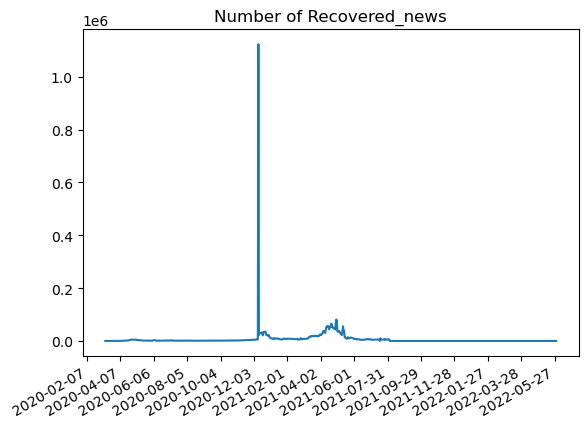

In [6]:
# İstatistiklerimizin grafiğine bakalım;

main_col_v2 = ["Case", "Death", "Recovered", "Case_new", "Death_new", "Recovered_new"]

date_1 = dt.datetime(2020,3,10)
date_2 = dt.datetime(2022,5,31)

days = mdates.drange(date_1, date_2, dt.timedelta(days=1))

for col in main_col_v2:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.plot(days,df[col])
    plt.gcf().autofmt_xdate()
    plt.title(f"Number of {col}s")
    plt.show()

    Yukarıdaki grafikleri inceledğimizide "Case" ve "Death değişkenlerinin son dönemlerinde değişkenelrin kümülatif olmasına rağmen  çok fazla değişim göstermediğini düşünüyoruz. Bunun sebebi;

* Veriler iyi tutulmamış olabilir,
* Yaz dönemine girildiği için olabilir,
* Hesaplama metriği değişmiş olabilir vs...

Biz burda yaz dönemine girdiğini düşünerek hareket edeceğiz.

    Ayrıca "Case_new" ve "Recovered_new"  değişkenlerinde anomali olduğunu görüyoruz. Bunlara yakından göz atalım.

Grafikten anomalilerin birbirine yakın bir yerde olduğu anlaşılıyor, oradaki indeksi bulmaya çalışalım, burdan yola çıkarak tarih bilgisi edineceğiz.

In [7]:
df["Case_new"].sort_values(ascending=False)

274    823225.0
695    111157.0
699    111096.0
693    110682.0
700    108563.0
         ...   
4           1.0
3           0.0
800         0.0
1           0.0
0           NaN
Name: Case_new, Length: 812, dtype: float64

In [8]:
df["Recovered_new"].sort_values(ascending=False)

276    1123456.0
416      81302.0
417      75182.0
415      68183.0
407      65593.0
         ...    
15           0.0
2            0.0
494          0.0
1            0.0
0            NaN
Name: Recovered_new, Length: 812, dtype: float64

In [9]:
# 274. ve 276. indeksler bizim için önemli...

df.loc[(270 < df.index) & (df.index < 290),]

,Date,Case,Death,Recovered,Month,Season,Weekday,Weekend,OfficailHoliday,BusinessDay,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Tam_kapanma,Kısmi_kapanma,Açık,Vaka_azaltıcı_olay,Case_new,Death_new,Recovered_new
271,2020-12-07,860432,15103,436270,12,1,1,0,0,0,0,0,0,0,1,0,2,32137.0,203.0,5017.0
272,2020-12-08,893630,15314,441515,12,1,1,0,0,0,0,0,0,0,1,0,2,33198.0,211.0,5245.0
273,2020-12-09,925342,15531,447361,12,1,1,0,0,0,0,0,0,0,1,0,2,31712.0,217.0,5846.0
274,2020-12-10,1748567,15751,452593,12,1,1,0,0,0,0,0,0,0,1,0,2,823225.0,220.0,5232.0
275,2020-12-11,1780673,15977,458109,12,1,1,0,0,0,0,0,0,0,1,0,2,32106.0,226.0,5516.0
276,2020-12-12,1809809,16199,1581565,12,1,0,1,0,1,0,0,0,1,0,0,20,29136.0,222.0,1123456.0
277,2020-12-13,1836728,16417,1603780,12,1,0,1,0,1,0,0,0,1,0,0,20,26919.0,218.0,22215.0
278,2020-12-14,1866345,16646,1631944,12,1,1,0,0,0,0,0,0,0,1,0,2,29617.0,229.0,28164.0
279,2020-12-15,1898447,16881,1661191,12,1,1,0,0,0,0,0,0,0,1,0,2,32102.0,235.0,29247.0
280,2020-12-16,1928165,17121,1691113,12,1,1,0,0,0,0,0,0,0,1,0,2,29718.0,240.0,29922.0


Yukarıda "2020-10-12" tarihine bakarsak sorunu gözlemleyebiliriz, o günlerde hesaplama metodolojisinin değiştiğine dair bir takım politikalar olduğunu hatırlıyoruz.

Hesaplama metedolojisi değişiminden dolayı "2020-12-12" tarihinden önceki verileri bir df'den çıkartıp grafiklerine bakacağız.

In [10]:
df = df.loc[("2020-12-12" < df['Date']), ]
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)

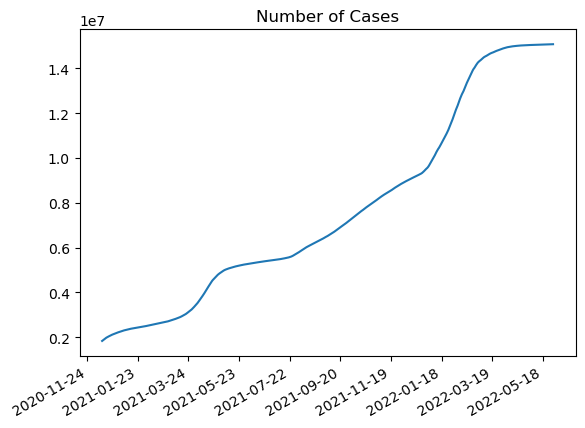

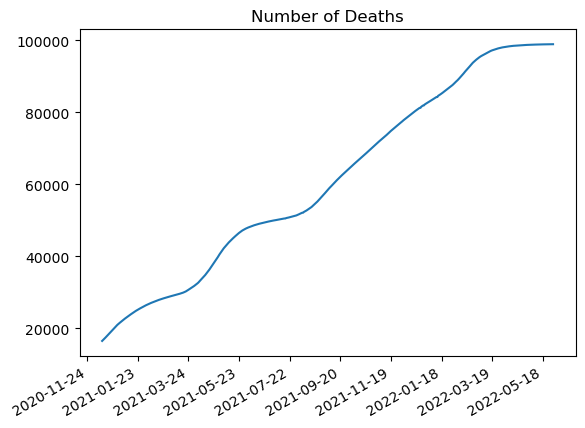

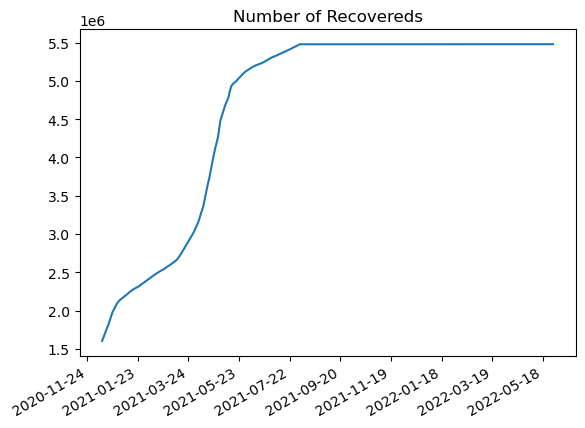

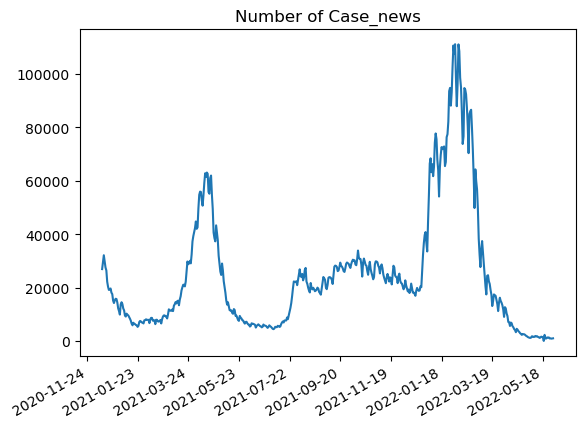

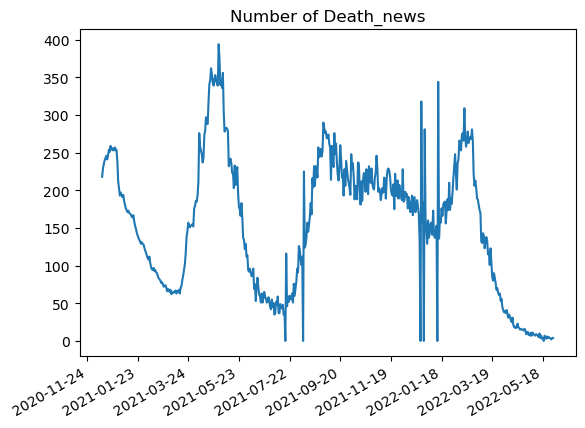

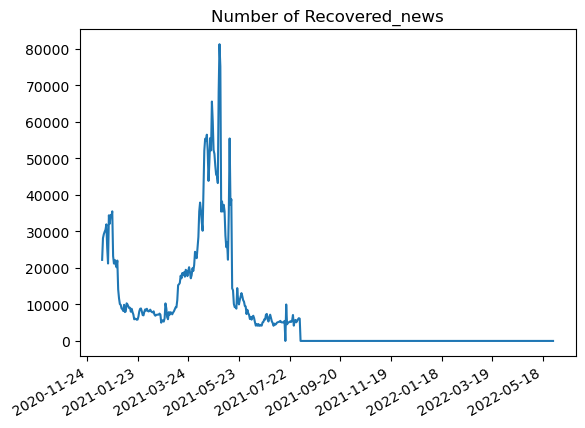

In [11]:
# İstatistik grafiklerine bakalım;

date_1 = dt.datetime(2020,12,12)
date_2 = dt.datetime(2022,5,31)

days = mdates.drange(date_1, date_2, dt.timedelta(days=1))

for col in main_col_v2:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.plot(days,df[col])
    plt.gcf().autofmt_xdate()
    plt.title(f"Number of {col}s")
    plt.show()

    Yukarıda daha net görüyoruz ki "Recovered_new" verisindeki durum yaz mevsimi ile açıklanamamaktadır. Burada bir düzeltmeye gideceğiz.

In [12]:
# Sorunu yakından gözlemleyelim;

df.loc[230 < df.index, ["Date", "Recovered_new"]]

,Date,Recovered_new
231,2021-08-01,5539.0
232,2021-08-02,5947.0
233,2021-08-03,6243.0
234,2021-08-04,6096.0
235,2021-08-05,3.0
...,...,...
530,2022-05-27,2.0
531,2022-05-28,2.0
532,2022-05-29,2.0
533,2022-05-30,2.0


"2021-04-08" tarihinden itibaren veride olan bozukluğu gözümüzle gördük. Bu durumu multiple linear regrassion ile çözeceğiz.

In [13]:
# Verideki sorunlu kısımı silelim;

df_1 = df[["Case", "Death", "Doses_admin", "People_partially_vaccinated", "People_fully_vaccinated", "Recovered"]]
df_1.loc[234 < df.index, ["Recovered"]] = None
df_1.isnull().sum()

Case                             0
Death                            0
Doses_admin                      0
People_partially_vaccinated      0
People_fully_vaccinated          0
Recovered                      300
dtype: int64

In [14]:
# Verimizi train ve test olarak ikiye ayıralım;

df_1_train = df_1.loc[234 > df.index,]
df_1_test  = df_1.loc[234 < df.index,]
df_1_test.drop("Recovered", axis=1, inplace=True)

# Train verimize bakalım;

df_1_train

,Case,Death,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Recovered
0,1836728,16417,0,0,0,1603780.0
1,1866345,16646,0,0,0,1631944.0
2,1898447,16881,0,0,0,1661191.0
3,1928165,17121,0,0,0,1691113.0
4,1955680,17364,0,0,0,1721607.0
...,...,...,...,...,...,...
229,5704713,51253,72897134,40661999,26437993,5449253.0
230,5727045,51332,73296729,41012715,27355633,5454360.0
231,5747935,51428,73631196,41062834,27472822,5459899.0
232,5770833,51519,73962498,41165345,27655792,5465846.0


<AxesSubplot:>

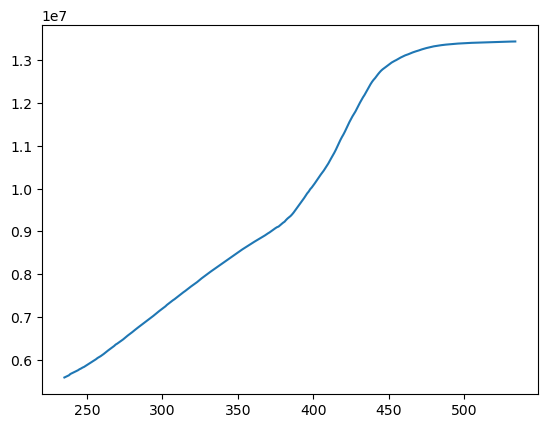

In [15]:
# Şimdi multiple linear regresyon ile modelimizi geliştirelim train verisini fit edelim;

from sklearn.linear_model import LinearRegression

Y_train = df_1_train["Recovered"]
X_train = df_1_train.drop("Recovered", axis=1)

reg_model = LinearRegression().fit(X_train, Y_train)

# Eksik değerleri tahmin edelim;
df_1_test_pred = reg_model.predict(df_1_test)

# Tahmin değerlerimizi test veri setine atalım ve grafiğine bakalım;
df_1_test_pred = [int(i.round()) for i in df_1_test_pred]
df_1_test["Recovered"] = df_1_test_pred
df_1_test["Recovered"].plot()

In [16]:
# Eksik veriyi df_1 isimli değişkene aktaralım;
df_1.loc[234 < df.index, ["Recovered"]] = df_1_test_pred

# Şimdi de ana df'mize aktaralım;
df["Recovered"] = df_1["Recovered"]
df["lag_1_Recovered"] = df["Recovered"].shift(1)
df["Recovered_new"] = df["Recovered"] - df["lag_1_Recovered"]
df.drop("lag_1_Recovered", axis=1, inplace=True)

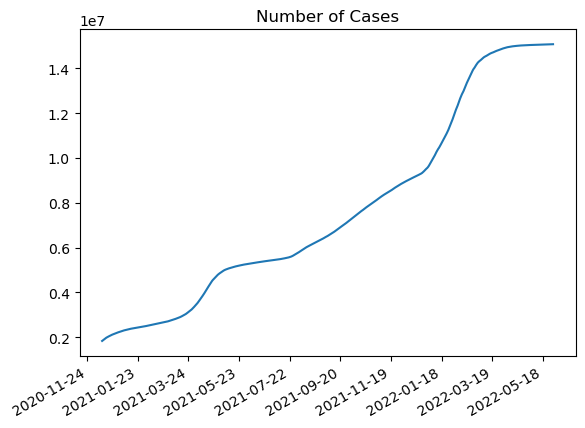

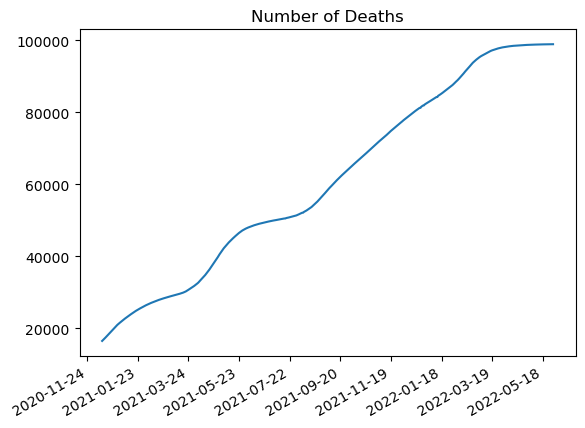

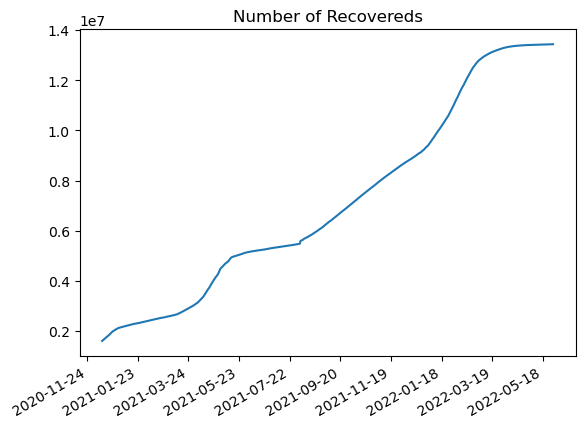

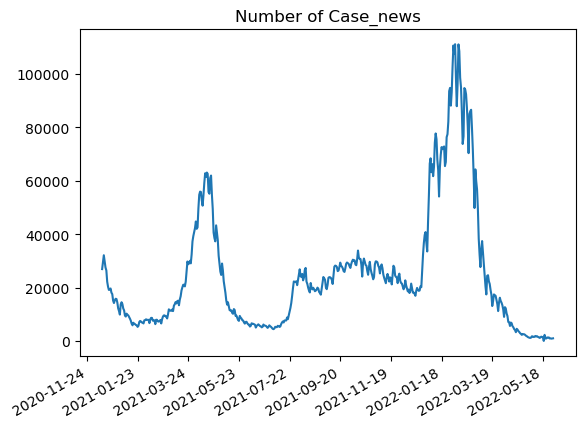

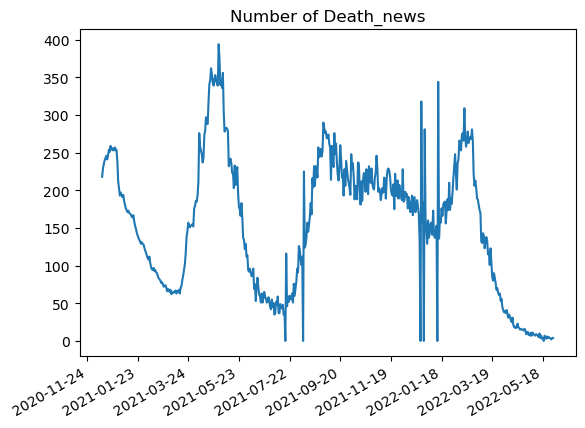

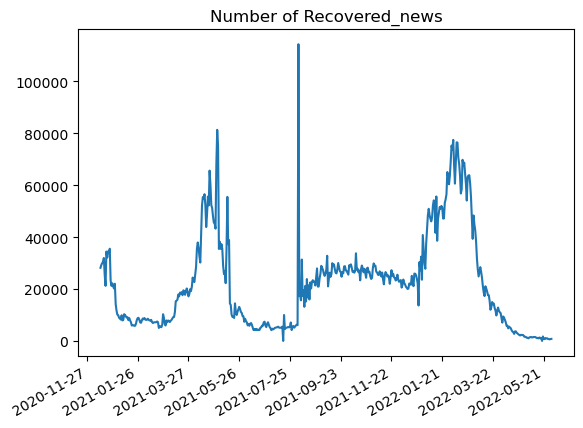

In [17]:
# o günkü istatistiklere bir kez daha bakalım;

for col in main_col_v2:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
    plt.plot(days,df[col])
    plt.gcf().autofmt_xdate()
    plt.title(f"Number of {col}s")
    plt.show()

        ACF Grafiğine bakalım

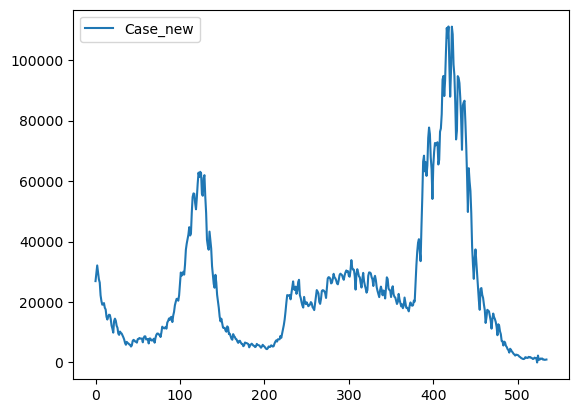

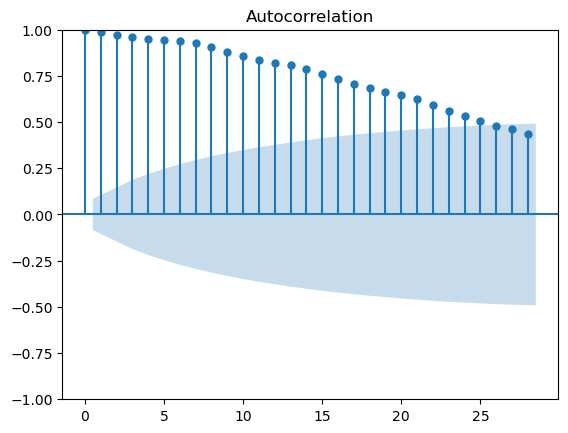

In [18]:
case_new = df[["Case_new"]]


case_new.plot()
plot_acf(case_new)
plt.show()

    Yukarıda ACF grafiğnde verinin trendli olduğunu görüyoruz. Herhangi başka bir lag da mevsimllik olup olmadığına bakmaki için veriden trendi çıkracağız.

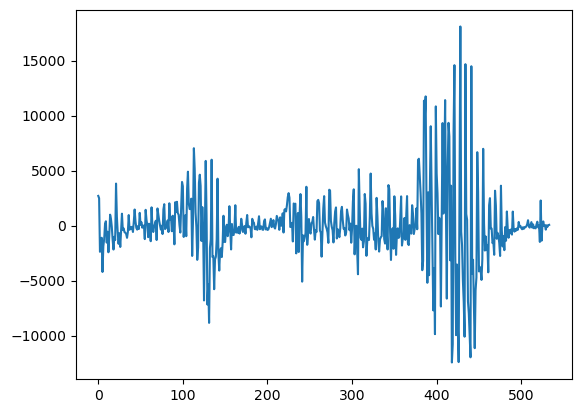

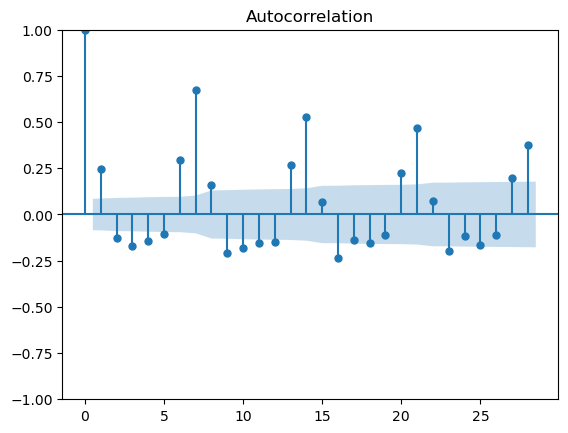

In [19]:
X = case_new.values
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
plt.plot(diff)
plt.show()

diff = pd.DataFrame(diff)

plot_acf(diff)
plt.show()

    7 ve 14 gün karantinalarının doğru bir politika olduğunu söyleyebiliriz.

### Feature Engineering

In [20]:
df.columns

# Verideki sütunların order'ını düzenleyelim;

df = df[['Date', 
         'Case', 'Death', 'Recovered',
         'Case_new', 'Death_new', 'Recovered_new',
         'Doses_admin', 'People_partially_vaccinated', 'People_fully_vaccinated',
         'Tam_kapanma', 'Kısmi_kapanma', 'Açık', 'Vaka_azaltıcı_olay',
         'Month', 'Season', 
         'Weekday', 'Weekend', 'OfficailHoliday', 'BusinessDay']]

# Oran Feature'si oluşturalım;
cols_list = ["Death", "Recovered"]

for col in cols_list:
    df[f"{col}/case"] = (df[col]/df["Case"])

cols_list_2 = ["Death_new", "Recovered_new"]

for col in cols_list_2:
    df[f"{col}/case_new"] = (df[col]/df["Case_new"])

df

,Date,Case,Death,Recovered,Case_new,Death_new,Recovered_new,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Tam_kapanma,Kısmi_kapanma,Açık,Vaka_azaltıcı_olay,Month,Season,Weekday,Weekend,OfficailHoliday,BusinessDay,Death/case,Recovered/case,Death_new/case_new,Recovered_new/case_new
0,2020-12-13,1836728,16417,1603780.0,26919.0,218.0,NaN,0,0,0,1,0,0,20,12,1,0,1,0,1,0.008938,0.873172,0.008098,NaN
1,2020-12-14,1866345,16646,1631944.0,29617.0,229.0,28164.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008919,0.874406,0.007732,0.950940
2,2020-12-15,1898447,16881,1661191.0,32102.0,235.0,29247.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008892,0.875026,0.007320,0.911065
3,2020-12-16,1928165,17121,1691113.0,29718.0,240.0,29922.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008879,0.877058,0.008076,1.006865
4,2020-12-17,1955680,17364,1721607.0,27515.0,243.0,30494.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008879,0.880311,0.008832,1.108268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2022-05-27,15069034,98952,13432052.0,940.0,4.0,770.0,147717865,57841428,53063994,0,0,1,0,5,2,1,0,0,0,0.006567,0.891368,0.004255,0.819149
531,2022-05-28,15070000,98955,13432764.0,966.0,3.0,712.0,147719809,57841732,53064473,0,0,1,0,5,2,0,1,0,1,0.006566,0.891358,0.003106,0.737060
532,2022-05-29,15070864,98957,13433362.0,864.0,2.0,598.0,147720907,57841876,53064752,0,0,1,0,5,2,0,1,0,1,0.006566,0.891347,0.002315,0.692130
533,2022-05-30,15071772,98961,13434116.0,908.0,4.0,754.0,147728185,57842849,53066241,0,0,1,0,5,2,1,0,0,0,0.006566,0.891343,0.004405,0.830396


    Eklediğimiz son 4 featurenin correlation'ununa bir bakalım;

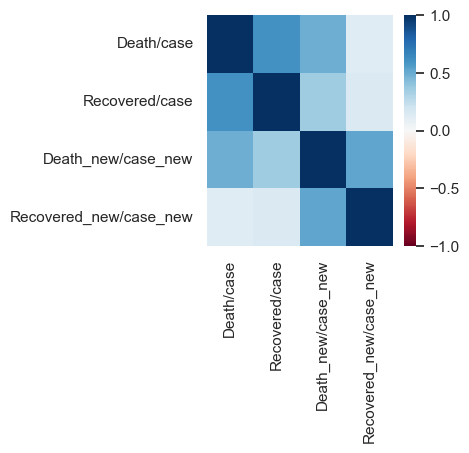

[]

In [21]:
hc_col = et.high_correlated_cols(df[["Death/case", "Recovered/case", "Death_new/case_new", "Recovered_new/case_new"]], \
                                 plot=True)
hc_col

    Oluşturduğumuz feature'lar arasıdna yüksek bir korelasyon yoktur.

In [22]:
def create_date_features(df):
    # date değişkeni içerisinden ayın kaçıncı günü olduğunu getirmesini ifade ediyoruz;
    df['day_of_month'] = df.Date.dt.day
    # date değişkeni içerisinden haftanın kaçıncı günü olduğunu getirmesini ifade ediyoruz;
    df['day_of_week'] = df.Date.dt.dayofweek
    # date değişkeni içerisinden yılı almasını istiyoruz;
    df['year'] = df.Date.dt.year
    # ayın başlangıcı mı, onu getirmesini istiyoruz;
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    # ayın sonu mu, onu getirmesini istiyoruz;
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df

In [23]:
# Date feature'larını oluşturalım;

create_date_features(df)

,Date,Case,Death,Recovered,Case_new,Death_new,Recovered_new,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Tam_kapanma,Kısmi_kapanma,Açık,Vaka_azaltıcı_olay,Month,Season,Weekday,Weekend,OfficailHoliday,BusinessDay,Death/case,Recovered/case,Death_new/case_new,Recovered_new/case_new,day_of_month,day_of_week,year,is_month_start,is_month_end
0,2020-12-13,1836728,16417,1603780.0,26919.0,218.0,NaN,0,0,0,1,0,0,20,12,1,0,1,0,1,0.008938,0.873172,0.008098,NaN,13,6,2020,0,0
1,2020-12-14,1866345,16646,1631944.0,29617.0,229.0,28164.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008919,0.874406,0.007732,0.950940,14,0,2020,0,0
2,2020-12-15,1898447,16881,1661191.0,32102.0,235.0,29247.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008892,0.875026,0.007320,0.911065,15,1,2020,0,0
3,2020-12-16,1928165,17121,1691113.0,29718.0,240.0,29922.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008879,0.877058,0.008076,1.006865,16,2,2020,0,0
4,2020-12-17,1955680,17364,1721607.0,27515.0,243.0,30494.0,0,0,0,0,1,0,2,12,1,1,0,0,0,0.008879,0.880311,0.008832,1.108268,17,3,2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2022-05-27,15069034,98952,13432052.0,940.0,4.0,770.0,147717865,57841428,53063994,0,0,1,0,5,2,1,0,0,0,0.006567,0.891368,0.004255,0.819149,27,4,2022,0,0
531,2022-05-28,15070000,98955,13432764.0,966.0,3.0,712.0,147719809,57841732,53064473,0,0,1,0,5,2,0,1,0,1,0.006566,0.891358,0.003106,0.737060,28,5,2022,0,0
532,2022-05-29,15070864,98957,13433362.0,864.0,2.0,598.0,147720907,57841876,53064752,0,0,1,0,5,2,0,1,0,1,0.006566,0.891347,0.002315,0.692130,29,6,2022,0,0
533,2022-05-30,15071772,98961,13434116.0,908.0,4.0,754.0,147728185,57842849,53066241,0,0,1,0,5,2,1,0,0,0,0.006566,0.891343,0.004405,0.830396,30,0,2022,0,0


        EDA

In [24]:
# 1 ocaktan - aralığa kadar bir yıllık covid verisini alıp inceleyeceğiz, 
# bu sebeple 1 yıllık covid df'si tanımlayalım;

df_year = df.loc[ (19<=df.index) & (df.index<384),]

cat_cols, num_cols, cat_but_car, num_but_cat = et.grab_col_names(df)

# for col in cat_cols:
#     for i in num_cols:
#         a = df_year.groupby(col).agg({ i: "mean"})
#         display(a)
#         a.plot(kind="bar", figsize= (6,6), legend=True)
#         plt.show()

    ARIMA

In [25]:
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
# Serimizi ve tarihimizi y isimli df'ye kaydedelim;
y = df[["Date","Case"]]
y

,Date,Case
0,2020-12-13,1836728
1,2020-12-14,1866345
2,2020-12-15,1898447
3,2020-12-16,1928165
4,2020-12-17,1955680
...,...,...
530,2022-05-27,15069034
531,2022-05-28,15070000
532,2022-05-29,15070864
533,2022-05-30,15071772


In [27]:
# logaritma alarak hesaplamamızı hızlandıralım;
y['Case'] = np.log1p(y["Case"].values)
y

,Date,Case
0,2020-12-13,14.423497
1,2020-12-14,14.439493
2,2020-12-15,14.456547
3,2020-12-16,14.472080
4,2020-12-17,14.486249
...,...,...
530,2022-05-27,16.528153
531,2022-05-28,16.528217
532,2022-05-29,16.528274
533,2022-05-30,16.528334


In [28]:
# Index'e date'yi atayalım ve kalan "Date" değişkenini dreop edelim;
y.index = y["Date"]
y.drop("Date", axis=1, inplace=True)

# Eksik değer var mı kontrol edelim;
y.isnull().sum()

Case    0
dtype: int64

In [29]:
# Verimizi train ve test olarak 2'ye ayıralım;
train = y[:'2022-04-26']
print(len(train)) 

test = y['2022-04-27':]
print(len(test))  

500
35


In [30]:
# Görselleştirme fonksiyonu tanımlayalım;

def plot_forecast(train, test, forecast, forecast_int = None):
        mape = mean_absolute_percentage_error(test, forecast)

        plt.figure(figsize=(8, 6))
        plt.title(f"MAPE: {mape:.3f}", size=18)

        plt.plot(train)
        plt.plot(test)
        plt.plot(forecast)

        test.plot(label="test", color="g")
        forecast.index = test.index
        forecast.plot(label="forecast", color="r")

        if forecast_int is not None:
            plt.fill_between(
                test.index,
                forecast_int["lower"],
                forecast_int["upper"],
                alpha=0.2,
                color="dimgray",
            )
        plt.legend(prop={"size": 16})
        plt.show()

        return mape

In [ ]:
# SARIMA modelimizi oluşturalım;

model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 365))

# Modelimize verilerimizi fit edelim;

sarima_model = model.fit(disp=0)

# "disp=0" argümanı ile model çıktılarını görmek istemediğimizi ifade ediyoruz.

In [ ]:
# Önümüzdeki 7 günü forecast edelim;

y_pred_test = sarima_model.get_forecast(steps=35)
y_pred_test
# Burada forecast için ".get_forecast()" metodunu kullanıyoruz 

In [ ]:
# ".predicted_mean" ile nesne içerisinden tahmin değerlerimizi çağıralım;

y_pred = y_pred_test.predicted_mean
y_pred.head()

# Görüyoruz ki aşağıdaki veri logaritma alınmış halde;

2022-04-27    16.525294
2022-04-28    16.525450
2022-04-29    16.525603
2022-04-30    16.525754
2022-05-01    16.525903
Freq: D, Name: predicted_mean, dtype: float64

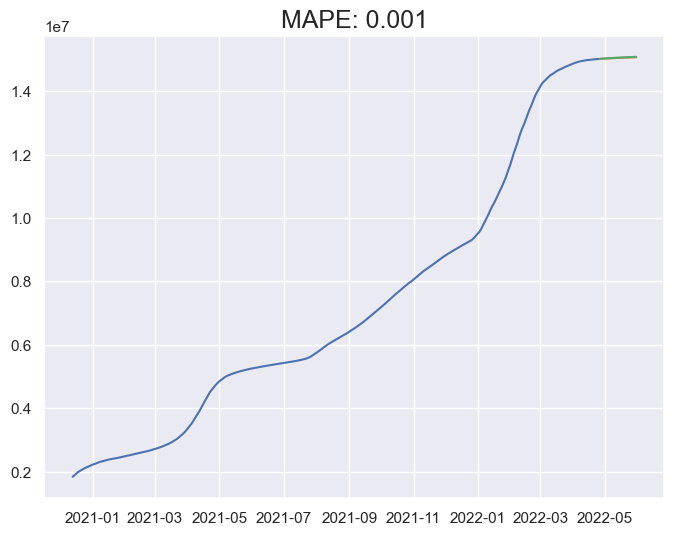

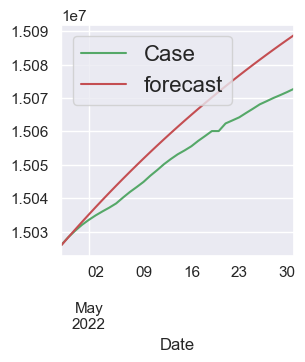

0.0005517274021833843

In [ ]:
# Bu ifadayi pandas serisine çavirelim, (görselleştirme fonksiyonumuzu çalıştırabilmek için)
# çevirirken de ters logaritma alma işlemi gerçekleştirelim;
y_pred = pd.Series(np.expm1(y_pred), index=test.index)
plot_forecast(np.expm1(train), np.expm1(test), y_pred)

    MAPE'miz çok düşük iyi bir model oluşturmuşuz.